# 2022-10-21 AMG

## Last time

* Multigrid
  * Spectral perspective
  * Factorization perspective
  
## Today
* Algebraic multigrid
* Smoothed aggregation
* Multigrid in PETSc
* Projects

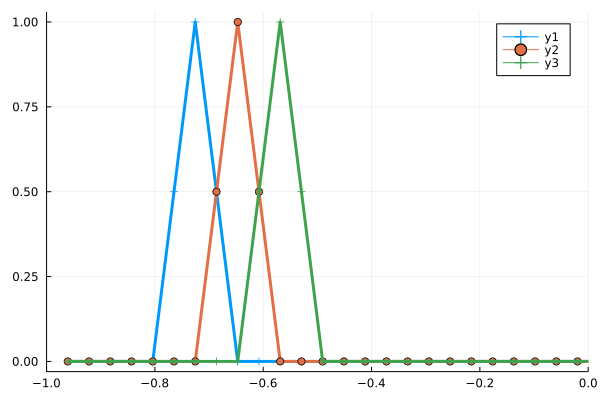

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, A # Hermitian(A)
end

function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
end
n = 50; x, A = laplace1d(n)
P = interpolate(n, 2)
plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))

# Galerkin approximation of $A$ in coarse space

$$ A_{2h} u_{2h} = P^T A_h P u_{2h} $$

size(A) = (400, 400)
size(A_2h) = (200, 200)


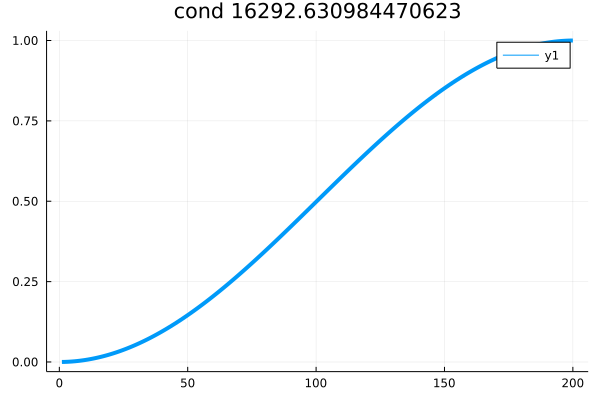

In [52]:
n = 400
x, A = laplace1d(n)
P = interpolate(n)
@show size(A)
A_2h = P' * A * P
@show size(A_2h)
L_2h = eigvals(A_2h)
plot(L_2h, title="cond $(L_2h[end]/L_2h[1])")

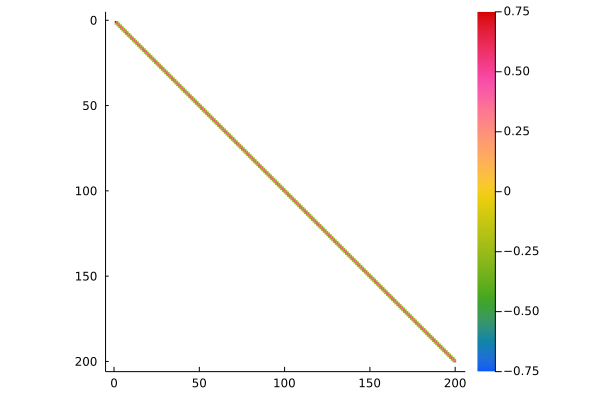

In [53]:
my_spy(A_2h)

# Coarse grid correction

Consider the $A$-orthogonal projection onto the range of $P$,
$$ S_c = P A_{2h}^{-1} P^T A $$

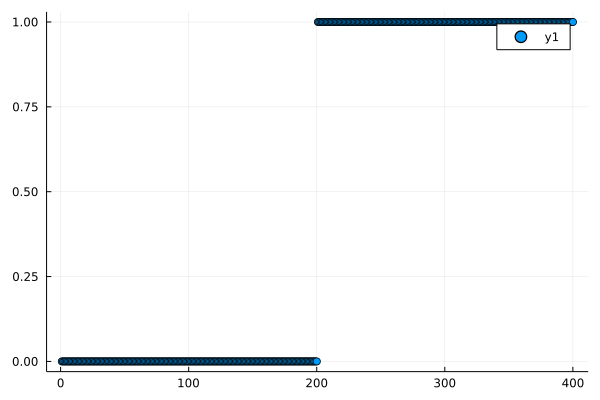

In [54]:
Sc = P * (A_2h \ P' * A)
Ls, Xs = eigen(I - Sc)
scatter(real.(Ls))

* This spectrum is typical for a projector. If $u$ is in the range of $P$, then $S_c u = u$. Why?
* For all vectors $v$ that are $A$-orthogonal to the range of $P$, we know that $S_c v = 0$. Why?

# A two-grid method

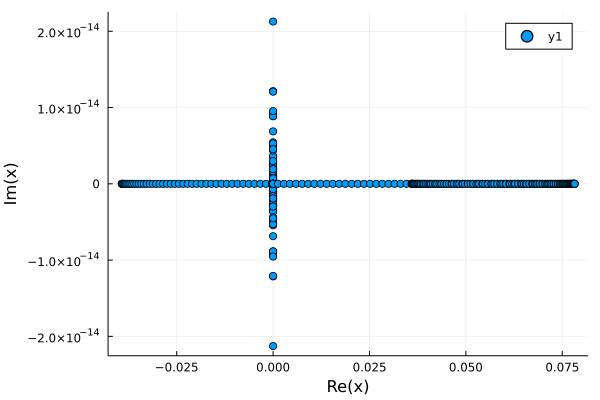

In [59]:
w = .67
T = (I - w*A)^1 * (I - Sc) * (I - w*A)^2
Lt = eigvals(T)
scatter(Lt)

* Can analyze these methods in terms of frequency.
* [LFAToolkit](https://jeremylt.github.io/LFAToolkit.jl/stable/examples/diffusion/#Diffusion-operator)

# Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$A = \begin{bmatrix} F & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B F^{-1} & I \end{bmatrix}
      \begin{bmatrix} F &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & F^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B F^{-1} B^T$.  $M$ has an inverse
$$
      \begin{bmatrix} I & -F^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} F^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B F^{-1} & I \end{bmatrix} .
$$

Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -F^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} F^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f F^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} A = I - P_f F^{-1} P_f^T J - P_c S^{-1} P_c^T A .$$

# Permute into C-F split

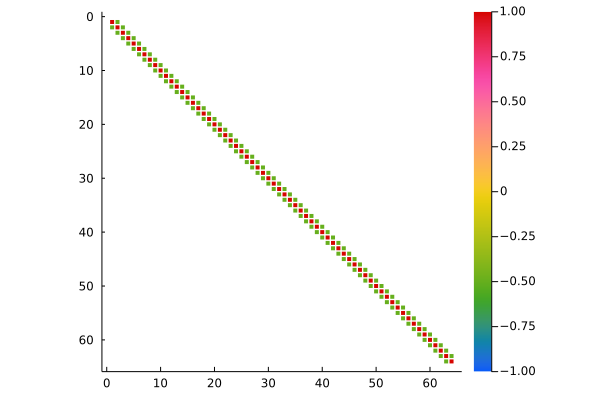

In [61]:
m = 64
x, A = laplace1d(m)
my_spy(A)

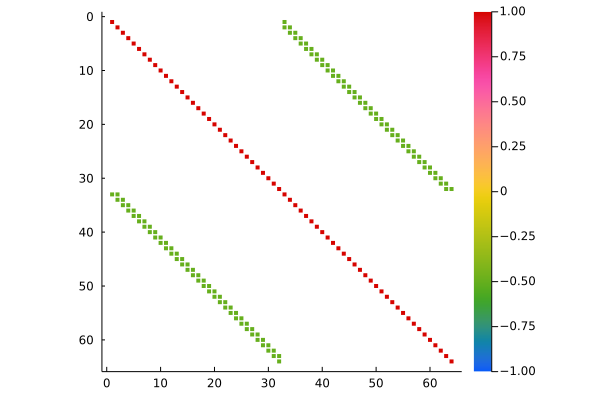

In [62]:
idx = vcat(1:2:m, 2:2:m)
J = A[idx, idx]
my_spy(J)

# Coarse basis functions

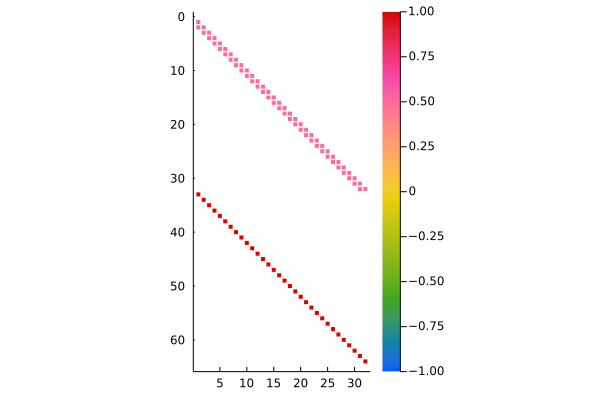

In [63]:
F = J[1:end÷2, 1:end÷2]
B = J[end÷2+1:end,1:end÷2]
P = [-F\B'; I]
my_spy(P)

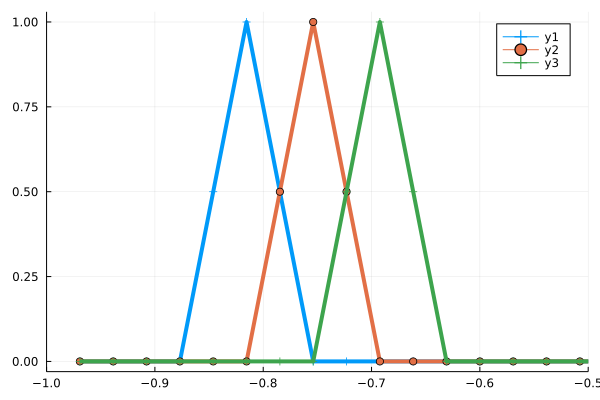

In [65]:
idxinv = zeros(Int64, m)
idxinv[idx] = 1:m
Pp = P[idxinv, :]
plot(x, Pp[:, 3:5], marker=:auto, xlims=(-1, -.5))

# From factorization to algebraic multigrid

* Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.
  * We can't choose enough coarse basis functions so that $F$ is diagonal, thereby making the minimal energy extension $-F^{-1} B^T$ sparse.

* Algebraic multigrid
  * Use matrix structure to aggregate or define C-points
  * Create an interpolation rule that balances sparsity with minimal energy

# Aggregation

Form aggregates from "strongly connected" dofs.

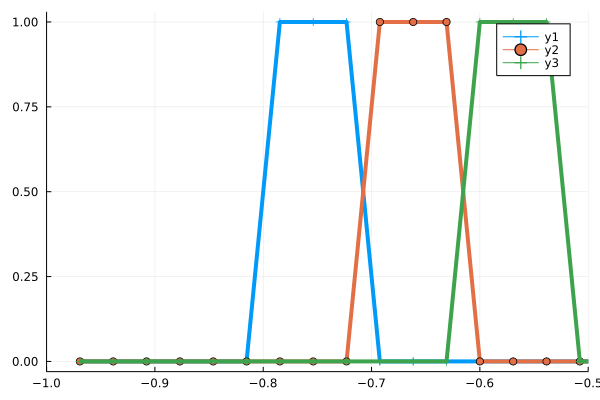

In [66]:
agg = 1 .+ (0:m-1) .÷ 3
mc = maximum(agg)
T = zeros(m, mc)
for (i, j) in enumerate(agg)
    T[i,j] = 1
end
plot(x, T[:, 3:5], marker=:auto, xlims=(-1, -.5))

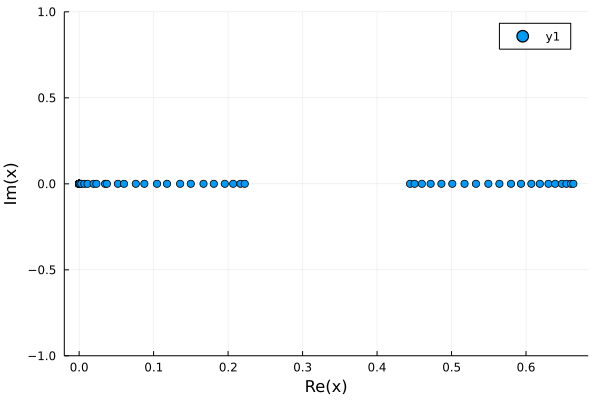

In [74]:
Sc = T * ((T' * A * T) \ T') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* simple and cheap method
* stronger smoothing (bigger `k`) doesn't help much; need more accurate coarse grid

# Smoothed aggregation

$$ P = (I - w A) T $$

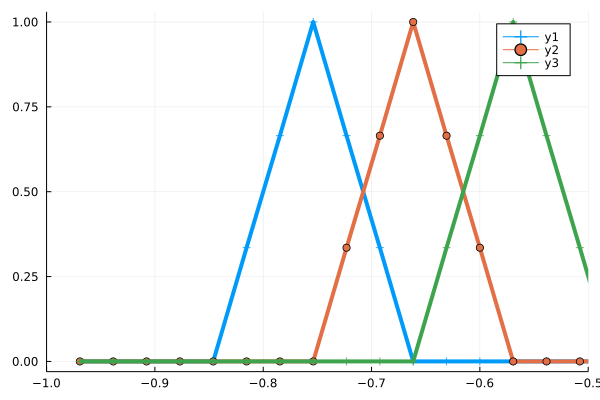

In [76]:
P = (I - w * A) * T
plot(x, P[:, 3:5], marker=:auto, xlims=(-1,-.5))

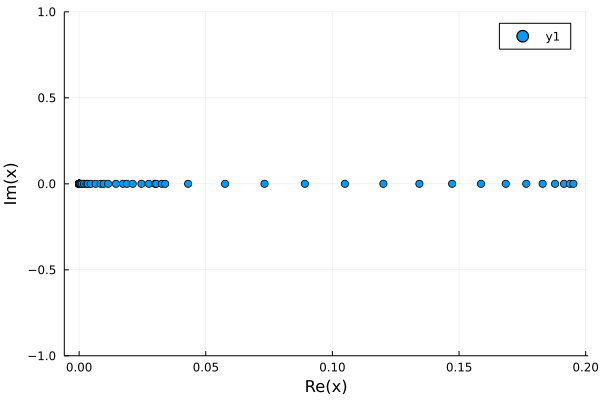

In [78]:
Sc = P * ((P' * A * P) \ P') * A
w = .67; k = 2
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* Eigenvalues are closer to zero; stronger smoothing (larger `k`) helps.
* Smoother can be made stronger using Chebyshev (like varying the damping between iterations in Jacobi)

# Multigrid in PETSc

## Geometric multigrid

* `-pc_type mg`
  * needs a grid hierarchy (automatic with `DM`)
  * `PCMGSetLevels()`
  * `PCMGSetInterpolation()`
  * `PCMGSetRestriction()`
* `-pc_mg_galerkin`
* `-pc_mg_cycle_type [v,w]`
* `-mg_levels_ksp_type chebyshev`
* `-mg_levels_pc_type jacobi`
* `-mg_coarse_pc_type svd`
  * `-mg_coarse_pc_svd_monitor` (report singular values/diagnose singular coarse grids)

## Algebraic multigrid

* `-pc_type gamg`
  * native PETSc implementation of smoothed aggregation (and experimental stuff), all `-pc_type mg` options apply.
  * [`MatSetNearNullSpace()`](https://petsc.org/release/docs/manualpages/Mat/MatSetNearNullSpace/)
  * [`MatNullSpaceCreateRigidBody()`](https://petsc.org/release/docs/manualpages/Mat/MatNullSpaceCreateRigidBody/)
  * [`DMPlexCreateRigidBody()`](https://petsc.org/release/docs/manualpages/DMPlex/DMPlexCreateRigidBody/)
  * `-pc_gamg_threshold .01` drops weak edges in strength graph
* `-pc_type ml`
  * similar to `gamg` with different defaults
* `-pc_type hypre`
  * Classical AMG (based on C-F splitting)
  * Manages its own grid hierarchy

# Searching for projects

## [GitHub codesearch](https://github.com/search)

* Check Insights -> Contributors
  * Sustained versus short-term activity
  * Number of stakeholders
  * `git shortlog -se --since=2016 | sort -n`
* Community signals
  * Code of Conduct
  * Contributing guidelines, pull request templates
  * Active review and mentoring in pull requests
* Continuous integration
  * Actions tab, also report in pull requests
  * Pipelines for repositories on GitLab

## Journals

### [Journal of Open Source Software](https://joss.theoj.org/papers)

* Papers on mature software with many users
* Immature research software with a few users, but best practices and intent to grow

### [Geoscientific Model Development](https://geoscientific-model-development.net/)

* Blends software and methods work

# Integration by parts

## One dimension

> it's the product rule backwards

\begin{align} \int_a^b d(uv) &= \int_a^b u dv + \int_a^b v du \\
(uv)_a^b &= \int_a^b u dv + \int_a^b v du \\
\int_a^b u dv &= (uv)_a^b - \int_a^b v du
\end{align}

> you can move the derivative to the other term; it'll cost you a minus sign and a boundary term

## Multiple dimensions

\begin{align}
\int_\Omega v \nabla\cdot \mathbf f = -\int_\Omega \nabla v \cdot \mathbf f + \int_{\partial \Omega} v \mathbf f \cdot \mathbf n
\end{align}

## Strong form

$$ -\nabla\cdot(\kappa \nabla u) = 0 $$

## Weak form
* multiply by a test function and integrate by parts

\begin{align} -\int_\Omega v \nabla\cdot(\kappa \nabla u) = 0, \forall v \\
\int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0
\end{align}